In [1]:
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

#  Step 1: Load dataset
file_path = 'cleaned_review_details_rough.xlsx'
reviews_df = pd.read_excel(file_path, engine='openpyxl')

In [2]:
# reviews_df1 = reviews_df[['brand',	'category', 'product_description', 'review_rating', 'review_rating', 'review_title', 'review_text', 'review_length', 'sentiment', 'rating_sentiment_diff', 'anomaly']].dropna()
reviews_df1 = reviews_df[['brand',	'category', 'product_description', 'review_rating', 'review_rating', 'review_title', 'review_text']].dropna()

reviews_df1.tail(20)

,brand,category,product_description,review_rating,review_rating,review_title,review_text
2121,Persil & Comfort,Homecare,Persil & Comfort New Baby Essential Laundry Ki...,5,5,Perfect for eczema and sensitive skin,हम हमेशा Persil non-bio वॉशिंग लिक्विड का उपयो...
2122,Sure,Personal Care,Sure Maximum Protection Clean Scent Cream Stic...,5,5,Easy to use,मैंने पहले भी यह उत्पाद खरीदा है और पसंद किया ...
2123,Simple,Personal Care,Simple Regeneration Age Resisting Night Cream ...,5,5,My all time favourite,यह अब तक की सबसे अच्छी नाइट क्रीम है जो मैंने ...
2125,St. Ives,Personal Care,St. Ives Fresh Skin Apricot Face Scrub 150ml,5,5,Best Scrub,"यह स्क्रब मुझे बहुत पसंद है, क्योंकि यह सच में..."
2126,Sure,Personal Care,Sure Maximum Protection Clean Scent Cream Stic...,5,5,Fantastic product. Really works.,मैंने इस डिओडोरेंट का 2 महीने से उपयोग किया और...
2128,Radox,Personal Care,Radox Feel Relaxed Shower Gel 250ml,5,5,Radox,मुझे रैडॉक्स उत्पाद बहुत पसंद हैं।
2129,Dove,Personal Care,Dove Original Aerosol Anti-perspirant Deodora...,5,5,Gorgeous,बहुत साफ़ और ताज़ा खुशबू जो पूरे दिन बनी रहती है।
2131,Simple,Personal Care,Simple Kind to Skin Exfoliating Facial Wipes 2...,2,2,FLUFF,"अच्छी स्क्रबिंग करने वाला उत्पाद, लेकिन कपड़ों..."
2132,St. Ives,Personal Care,St. Ives Fresh Skin Apricot Face Scrub 150ml,5,5,Love it!,"हाल ही में इसे खरीदा, इसकी खुशबू मुझे बहुत पसं..."
2134,Dove,Personal Care,Dove Maximum Protection Original Clean Anti-pe...,5,5,Amazing product,"2 महीने से उपयोग कर रहा हूं, अब पसीना नहीं आता।"


In [3]:
#  Step 2: Drop Missing Values
reviews_df = reviews_df[['review_text', 'review_rating']].dropna()

# Step 3: Initialize Hugging Face sentiment analysis pipeline
sentiment_analyzer = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

#  Step 4: Apply Sentiment Analysis In Batches To Prevent Crash
start_time = time.time()

In [4]:
def get_transformer_sentiment(text):
    try:
        result = sentiment_analyzer(text)[0]
        label = result['label']
        #  Map the BERT labels to Positive, Neutral, Negative
        if label in ['1 star', '2 stars']:
            return 'Negative'
        elif label == '3 stars':
            return 'Neutral'
        else:
            return 'Positive'
    except:
        return 'Neutral'

In [5]:
#  Step 5: Apply Sentiment Analysis in batches
batch_size = 1000  # Prevent crash
for i in range(0, len(reviews_df), batch_size):
    reviews_df.loc[i:i+batch_size, 'bert_sentiment_label'] = reviews_df.loc[i:i+batch_size, 'review_text'].apply(get_transformer_sentiment)

print(f" Sentiment Analysis Completed in {round(time.time() - start_time, 2)} seconds.")

 Sentiment Analysis Completed in 302.76 seconds.


In [6]:
#  Step 6: Map the Actual Rating to Sentiment
def categorize_rating(rating):
    if rating >= 4:
        return 'Positive'
    elif rating <= 2:
        return 'Negative'
    else:
        return 'Neutral'

reviews_df['rating_label'] = reviews_df['review_rating'].apply(categorize_rating)

In [7]:
#  Step 7: Evaluate the Model
print(" Classification Report (BERT Sentiment):")
print(classification_report(reviews_df['rating_label'], reviews_df['bert_sentiment_label']))

 Classification Report (BERT Sentiment):
              precision    recall  f1-score   support

    Negative       0.47      0.74      0.58       211
     Neutral       0.20      0.43      0.27        99
    Positive       0.97      0.84      0.90      1839

    accuracy                           0.81      2149
   macro avg       0.55      0.67      0.58      2149
weighted avg       0.89      0.81      0.84      2149



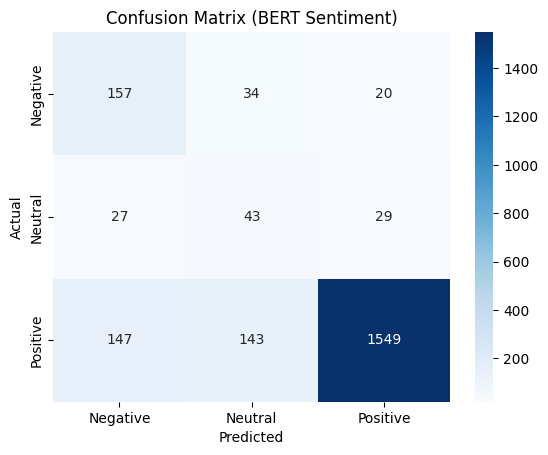

In [8]:
#  Step 8: Confusion Matrix
conf_matrix = confusion_matrix(reviews_df['rating_label'], reviews_df['bert_sentiment_label'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix (BERT Sentiment)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [9]:
#  Step 9: Save the Result to CSV
output_file = 'review_sentiment_results.csv'
reviews_df.to_csv(output_file, index=False, encoding='utf-8-sig')
print(f" Sentiment analysis result saved to: {output_file}")

 Sentiment analysis result saved to: review_sentiment_results.csv


In [10]:
reviews_df.head(20)

,review_text,review_rating,bert_sentiment_label,rating_label
0,"जैसे-जैसे आप बड़े होते हैं, आपको पता चल जाता ह...",5,Positive,Positive
1,"तीन विशाल मार्माइट जार, जो शायद पूरी ज़िंदगी त...",5,Negative,Positive
2,उत्कृष्ट,4,Positive,Positive
3,धीमी पकाने के लिए एक बढ़िया फ्लेवर बूस्टर।,5,Positive,Positive
4,"जो कहा गया है, वही करता है।",5,Positive,Positive
5,उत्कृष्ट,4,Positive,Positive
6,"तीन बड़े मार्माइट जार, जो पूरी ज़िंदगी तक चलें...",5,Positive,Positive
7,धीमी पकाने के लिए एक बेहतरीन फ्लेवर एडिशन।,5,Positive,Positive
8,"उत्कृष्ट वस्तु, पुरुषों के लिए अच्छी।",4,Positive,Positive
9,"धन्यवाद, मैं बहुत खुश हूँ।",5,Negative,Positive


In [11]:
reviews_df.tail(20)

,review_text,review_rating,bert_sentiment_label,rating_label
2129,बहुत साफ़ और ताज़ा खुशबू जो पूरे दिन बनी रहती है।,5,Positive,Positive
2130,वैसलीन एक ऐसा उत्पाद है जिसके कई उपयोग हैं।,5,Positive,Positive
2131,"अच्छी स्क्रबिंग करने वाला उत्पाद, लेकिन कपड़ों...",2,Neutral,Negative
2132,"हाल ही में इसे खरीदा, इसकी खुशबू मुझे बहुत पसं...",5,Positive,Positive
2133,"मैं इसे रोज़ उपयोग करता हूं, बहुत अच्छा मॉइस्च...",4,Positive,Positive
2134,"2 महीने से उपयोग कर रहा हूं, अब पसीना नहीं आता।",5,Negative,Positive
2135,मैं वैसलीन से प्यार करता हूं।,5,Positive,Positive
2136,यह उत्पाद मेरी त्वचा को मुलायम और चमकदार बनाता...,4,Positive,Positive
2137,"मैं हमेशा इसे उपयोग करता हूं, बहुत बढ़िया है।",5,Negative,Positive
2138,यह उत्पाद मेरी त्वचा को बहुत अच्छी तरह साफ़ कर...,5,Positive,Positive
